In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [2]:
len(glob("freezes/models/*/model.h5"))

0

In [3]:
metrics = ["loss", "accuracy", "precision", "recall"]
column_names = ["train_"+i for i in metrics] + ["val_"+i for i in metrics]
column_names

['train_loss',
 'train_accuracy',
 'train_precision',
 'train_recall',
 'val_loss',
 'val_accuracy',
 'val_precision',
 'val_recall']

In [5]:
configs = pd.DataFrame([i.split("\\")[-1].replace("leaky_relu", "leaky-relu").split("_")+[i.split("\\")[-1]] for i in glob("logs/*")], columns = ["layer", "activation", "optimizer", "lr", "name"])
configs.lr = configs.lr.astype(float)
configs.layer = configs.layer.astype(int)
configs["curves"] = ("logs/"+configs.name+"/curves.csv").apply(lambda fname: pd.read_csv(fname, names=column_names))
configs

,layer,activation,optimizer,lr,name,curves
0,256,gelu,adagrad,1.0000,256_gelu_adagrad_1,train_loss train_accuracy ...
1,256,gelu,adagrad,10.0000,256_gelu_adagrad_10,train_loss train_accuracy ...
2,256,gelu,adagrad,0.1000,256_gelu_adagrad_1e-1,train_loss train_accuracy ...
3,256,gelu,adagrad,0.0100,256_gelu_adagrad_1e-2,train_loss train_accuracy ...
4,256,gelu,adagrad,0.0010,256_gelu_adagrad_1e-3,train_loss train_accuracy ...
...,...,...,...,...,...,...
332,512,swish,nadam,30.0000,512_swish_nadam_30,train_loss train_accuracy ...
333,512,swish,nadam,0.3000,512_swish_nadam_3e-1,train_loss train_accuracy ...
334,512,swish,nadam,0.0300,512_swish_nadam_3e-2,train_loss train_accuracy ...
335,512,swish,nadam,0.0030,512_swish_nadam_3e-3,train_loss train_accuracy ...


In [6]:
train_accuracy = configs[configs.layer == 256].drop(columns=["layer", "name"]).set_index(["activation", "optimizer", "lr"])["curves"].apply(lambda df: df["train_accuracy"])[list(range(1,21))].stack().reset_index().rename(columns={"level_3":"epoch", 0:"train_accuracy"})
val_accuracy = configs[configs.layer == 256].drop(columns=["layer", "name"]).set_index(["activation", "optimizer", "lr"])["curves"].apply(lambda df: df["val_accuracy"])[list(range(1,21))].stack().reset_index().rename(columns={"level_3":"epoch", 0:"val_accuracy"})

In [7]:
accuracy_curve = pd.merge(train_accuracy, val_accuracy)
accuracy_curve[["train_accuracy", "val_accuracy"]] = accuracy_curve[["train_accuracy", "val_accuracy"]].astype(float)
accuracy_curve

,activation,optimizer,lr,epoch,train_accuracy,val_accuracy
0,gelu,adagrad,1.0000,1,0.845974,0.853670
1,gelu,adagrad,1.0000,2,0.855328,0.856559
2,gelu,adagrad,1.0000,3,0.855651,0.856091
3,gelu,adagrad,1.0000,4,0.856310,0.857142
4,gelu,adagrad,1.0000,5,0.855845,0.855246
...,...,...,...,...,...,...
3595,swish,nadam,0.0003,16,0.856156,0.856814
3596,swish,nadam,0.0003,17,0.856373,0.856817
3597,swish,nadam,0.0003,18,0.856696,0.856776
3598,swish,nadam,0.0003,19,0.856867,0.856678


### By Activation

In [8]:
meaner = accuracy_curve.groupby(["activation", "epoch"])[["train_accuracy", "val_accuracy"]].mean().unstack().rename(
    columns=dict(train_accuracy="mean_train_accuracy", val_accuracy="mean_val_accuracy")
)
minner = accuracy_curve.groupby(["activation", "epoch"])[["train_accuracy", "val_accuracy"]].min().unstack().rename(
    columns=dict(train_accuracy="min_train_accuracy", val_accuracy="min_val_accuracy")
)
maxxer = accuracy_curve.groupby(["activation", "epoch"])[["train_accuracy", "val_accuracy"]].max().unstack().rename(
    columns=dict(train_accuracy="max_train_accuracy", val_accuracy="max_val_accuracy")
)
activator = pd.concat([meaner, minner, maxxer], axis=1).reset_index()
activator

activation mean_train_accuracy                                          \
epoch                               1         2         3         4         5   
0            gelu            0.794865  0.835116  0.840536  0.840940  0.843900   
1      leaky-relu            0.795336  0.828652  0.832016  0.828350  0.832500   
2            relu            0.806637  0.828601  0.830508  0.834651  0.838488   
3         sigmoid            0.765275  0.809949  0.812804  0.814242  0.814367   
4           swish            0.817704  0.842113  0.842060  0.840755  0.842483   

                                               ... max_val_accuracy            \
epoch         6         7         8         9  ...               11        12   
0      0.843675  0.845320  0.844203  0.842887  ...         0.860759  0.861206   
1      0.832665  0.835849  0.835782  0.836170  ...         0.858968  0.859589   
2      0.840607  0.842540  0.842334  0.842483  ...         0.860901  0.860103   
3      0.815446  0.815020  0.816146  0.814967  ...         0.860106  0.860480   
4      0.841497  0.843724  0.844408  0.842182  ...         0.860564  0.860988   

                                                                             \
epoch        13        14        15        16        17        18        19   
0      0.860669  0.861322  0.860959  0.861778  0.861229  0.861784  0.861293   
1      0.860065  0.858199  0.859859  0.858457  0.859647  0.859380  0.859633   
2      0.860765  0.861075  0.860228  0.860712  0.861142  0.861197  0.860625   
3      0.859580  0.860083  0.861006  0.860695  0.860771  0.860123  0.860744   
4      0.860762  0.860538  0.860628  0.860977  0.860811  0.860974  0.861232   

                 
epoch        20  
0      0.861952  
1      0.860071  
2      0.860979  
3      0.860733  
4      0.861708  

[5 rows x 121 columns]

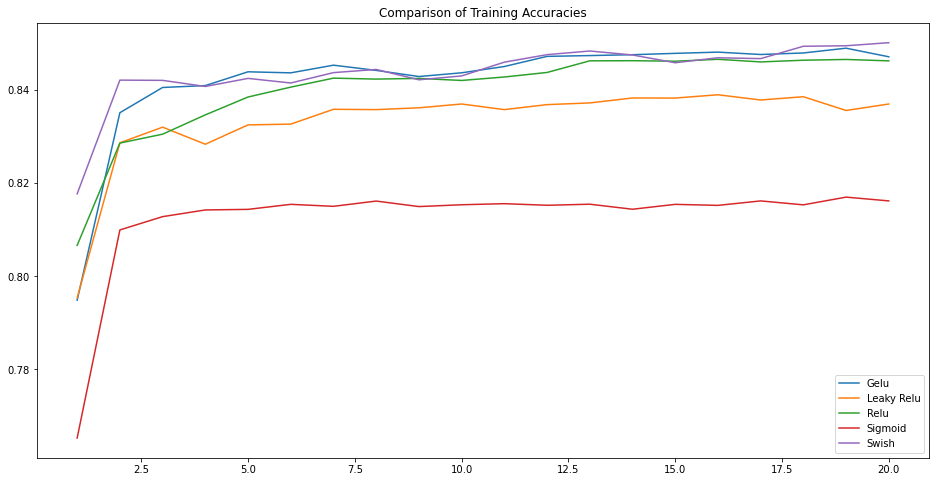

In [36]:
def plot_accuracies(row):
    #print(row.keys())
    activation = row["activation"].values[0].replace("-", " ").title()
    
    epochs = np.arange(1, 21, 1)
    
    mean_train = row["mean_train_accuracy"].values
    min_train = row["min_train_accuracy"].values
    max_train = row["max_train_accuracy"].values
    
    mean_val = row["mean_val_accuracy"].values
    min_val = row["min_val_accuracy"].values
    max_val = row["max_val_accuracy"].values
    
    plt.plot(epochs, mean_train, label=activation)#"Training")
    
    #plt.plot(epochs, mean_val, label="Validation")

plt.figure(figsize=(16, 8))
plt.title("Comparison of Training Accuracies")
activator.apply(plot_accuracies, axis=1)
plt.legend()

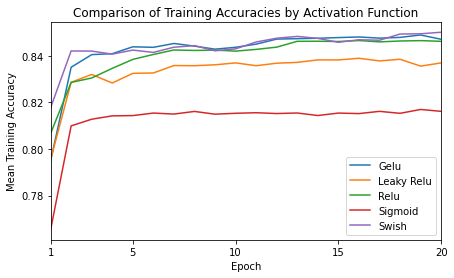

In [49]:
plt.figure(figsize=(7, 4))
plt.title(r"Comparison of Training Accuracies by Activation Function")

activator.apply(plot_accuracies, axis=1)
plt.xlim(1, 20)
plt.legend()

plt.xticks(np.hstack([np.array([1]), np.arange(5, 21, 5)]))

plt.xlabel("Epoch")
plt.ylabel("Mean Training Accuracy")

plt.savefig("actcomp.png", dpi=1000)

### By Optimizer

In [50]:
meaner = accuracy_curve.groupby(["optimizer", "epoch"])[["train_accuracy", "val_accuracy"]].mean().unstack().rename(
    columns=dict(train_accuracy="mean_train_accuracy", val_accuracy="mean_val_accuracy")
)
minner = accuracy_curve.groupby(["optimizer", "epoch"])[["train_accuracy", "val_accuracy"]].min().unstack().rename(
    columns=dict(train_accuracy="min_train_accuracy", val_accuracy="min_val_accuracy")
)
maxxer = accuracy_curve.groupby(["optimizer", "epoch"])[["train_accuracy", "val_accuracy"]].max().unstack().rename(
    columns=dict(train_accuracy="max_train_accuracy", val_accuracy="max_val_accuracy")
)
optimizor = pd.concat([meaner, minner, maxxer], axis=1).reset_index()
optimizor

optimizer mean_train_accuracy                                          \
epoch                             1         2         3         4         5   
0       adagrad            0.781290  0.817068  0.824123  0.827134  0.829751   
1          adam            0.809204  0.839490  0.839486  0.837456  0.841261   
2         nadam            0.797396  0.830101  0.831145  0.830773  0.832030   

                                               ... max_val_accuracy            \
epoch         6         7         8         9  ...               11        12   
0      0.831557  0.832898  0.833907  0.834515  ...         0.859293  0.859180   
1      0.842830  0.843303  0.841692  0.838342  ...         0.860901  0.860988   
2      0.829949  0.833271  0.834125  0.834357  ...         0.860573  0.861206   

                                                                             \
epoch        13        14        15        16        17        18        19   
0      0.859197  0.859717  0.859490  0.859874  0.859517  0.859699  0.860001   
1      0.860765  0.861075  0.861006  0.860997  0.861203  0.861258  0.861293   
2      0.860669  0.861322  0.860959  0.861778  0.861229  0.861784  0.861232   

                 
epoch        20  
0      0.860109  
1      0.861708  
2      0.861952  

[3 rows x 121 columns]

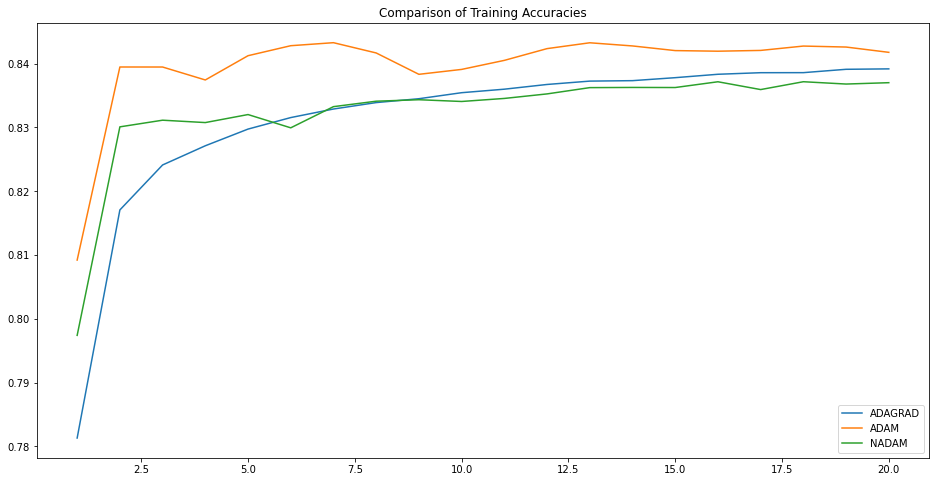

In [51]:
def plot_accuracies(row):
    #print(row.keys())
    optimizer = row["optimizer"].values[0].upper()
    
    epochs = np.arange(1, 21, 1)
    
    mean_train = row["mean_train_accuracy"].values
    min_train = row["min_train_accuracy"].values
    max_train = row["max_train_accuracy"].values
    
    mean_val = row["mean_val_accuracy"].values
    min_val = row["min_val_accuracy"].values
    max_val = row["max_val_accuracy"].values
    
    plt.plot(epochs, mean_train, label=optimizer)#"Training")
    
    #plt.plot(epochs, mean_val, label="Validation")

plt.figure(figsize=(16, 8))
plt.title("Comparison of Training Accuracies")
optimizor.apply(plot_accuracies, axis=1)
plt.legend()

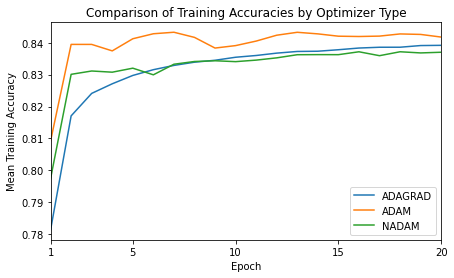

In [53]:
plt.figure(figsize=(7, 4))
plt.title(r"Comparison of Training Accuracies by Optimizer Type")

optimizor.apply(plot_accuracies, axis=1)
plt.xlim(1, 20)
plt.legend()

plt.xticks(np.hstack([np.array([1]), np.arange(5, 21, 5)]))

plt.xlabel("Epoch")
plt.ylabel("Mean Training Accuracy")

plt.savefig("opcomp.png", dpi=1000)

### Learning Rate

In [54]:
meaner = accuracy_curve.groupby(["lr", "epoch"])[["train_accuracy", "val_accuracy"]].mean().unstack().rename(
    columns=dict(train_accuracy="mean_train_accuracy", val_accuracy="mean_val_accuracy")
)
minner = accuracy_curve.groupby(["lr", "epoch"])[["train_accuracy", "val_accuracy"]].min().unstack().rename(
    columns=dict(train_accuracy="min_train_accuracy", val_accuracy="min_val_accuracy")
)
maxxer = accuracy_curve.groupby(["lr", "epoch"])[["train_accuracy", "val_accuracy"]].max().unstack().rename(
    columns=dict(train_accuracy="max_train_accuracy", val_accuracy="max_val_accuracy")
)
lror = pd.concat([meaner, minner, maxxer], axis=1).reset_index()
lror

lr mean_train_accuracy                                          \
epoch                            1         2         3         4         5   
0       0.0001            0.640308  0.747430  0.763570  0.773978  0.782496   
1       0.0003            0.787089  0.841996  0.848934  0.850574  0.851125   
2       0.0010            0.808032  0.850661  0.851077  0.851480  0.851881   
3       0.0030            0.829993  0.851406  0.852509  0.853308  0.854202   
4       0.0100            0.846730  0.854526  0.855740  0.856375  0.856599   
5       0.0300            0.847829  0.855383  0.855716  0.855319  0.855861   
6       0.1000            0.841165  0.854111  0.854430  0.851196  0.854361   
7       0.3000            0.825297  0.849782  0.851132  0.846363  0.848059   
8       1.0000            0.804638  0.835804  0.836609  0.839426  0.839514   
9       3.0000            0.791830  0.822349  0.825958  0.822473  0.823839   
10     10.0000            0.776588  0.795259  0.799298  0.801851  0.799019   
11     30.0000            0.752059  0.787929  0.784043  0.779107  0.795216   

                                               ... max_val_accuracy            \
epoch         6         7         8         9  ...               11        12   
0      0.789605  0.794683  0.798117  0.801065  ...         0.856367  0.856376   
1      0.851394  0.851466  0.851516  0.851570  ...         0.856591  0.857316   
2      0.852262  0.852591  0.853058  0.853384  ...         0.858399  0.858921   
3      0.854700  0.855217  0.855595  0.856005  ...         0.859984  0.859766   
4      0.856845  0.857085  0.857242  0.857229  ...         0.860759  0.861206   
5      0.856385  0.856850  0.856723  0.856902  ...         0.860901  0.860988   
6      0.855406  0.855479  0.855445  0.855377  ...         0.858675  0.858834   
7      0.835860  0.844467  0.846880  0.847456  ...         0.859293  0.859180   
8      0.841384  0.839949  0.841309  0.842191  ...         0.857859  0.858593   
9      0.826712  0.826497  0.825625  0.825039  ...         0.857923  0.857548   
10     0.803608  0.808420  0.807428  0.808698  ...         0.855339  0.855447   
11     0.793179  0.795187  0.789960  0.773934  ...         0.855345  0.854567   

                                                                             \
epoch        13        14        15        16        17        18        19   
0      0.856503  0.856419  0.856564  0.856556  0.856434  0.856277  0.856834   
1      0.857168  0.857415  0.857255  0.857717  0.857908  0.857998  0.857940   
2      0.858985  0.859000  0.858971  0.859252  0.859339  0.859296  0.859305   
3      0.860170  0.860187  0.860474  0.860178  0.860338  0.860454  0.860570   
4      0.860765  0.860887  0.860959  0.861778  0.861229  0.861784  0.861293   
5      0.860762  0.861322  0.861006  0.860977  0.861203  0.861197  0.860750   
6      0.859322  0.858829  0.858480  0.858863  0.859392  0.859017  0.858936   
7      0.859197  0.859717  0.859490  0.859874  0.859517  0.859699  0.860001   
8      0.857964  0.858521  0.858048  0.857885  0.858080  0.859220  0.858248   
9      0.856553  0.857728  0.857281  0.858149  0.856985  0.858657  0.858367   
10     0.855180  0.853836  0.854019  0.854187  0.853383  0.855348  0.855508   
11     0.855546  0.856013  0.854721  0.852457  0.854199  0.849975  0.855511   

                 
epoch        20  
0      0.856335  
1      0.858071  
2      0.859618  
3      0.860454  
4      0.861952  
5      0.861331  
6      0.859714  
7      0.860109  
8      0.859159  
9      0.857226  
10     0.856117  
11     0.857583  

[12 rows x 121 columns]

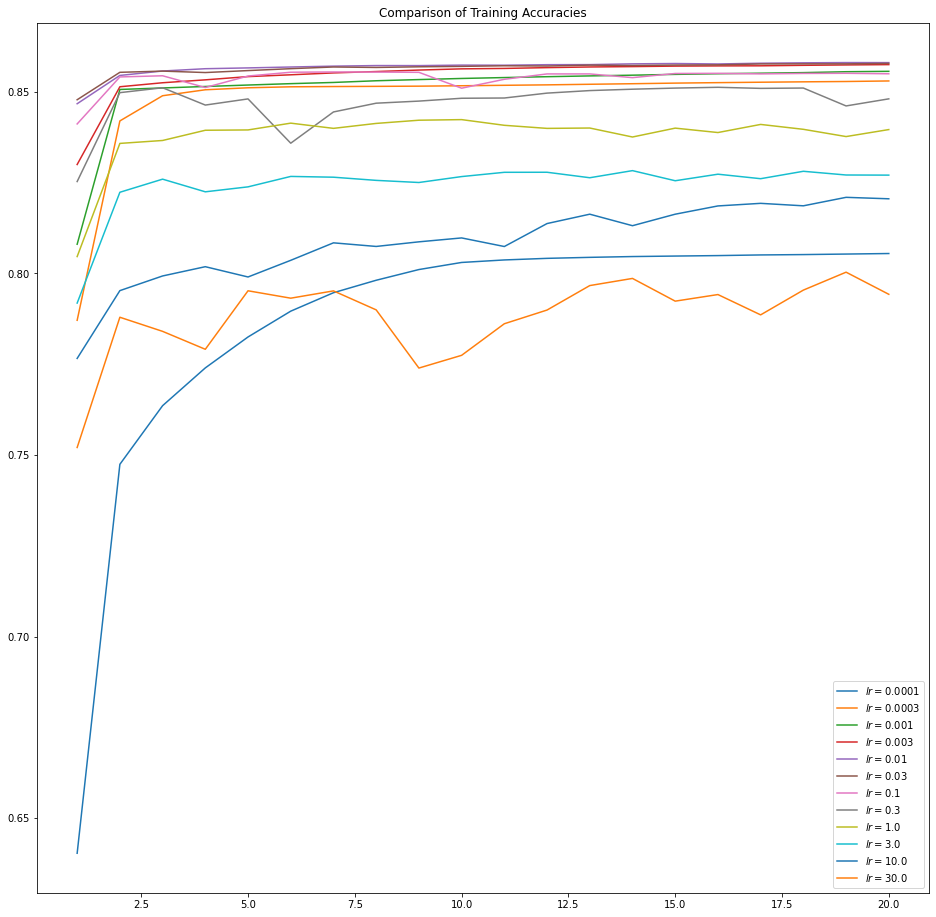

In [55]:
def plot_accuracies(row):
    #print(row.keys())
    lr = row["lr"].values[0]
    
    epochs = np.arange(1, 21, 1)
    
    mean_train = row["mean_train_accuracy"].values
    min_train = row["min_train_accuracy"].values
    max_train = row["max_train_accuracy"].values
    
    mean_val = row["mean_val_accuracy"].values
    min_val = row["min_val_accuracy"].values
    max_val = row["max_val_accuracy"].values
    
    plt.plot(epochs, mean_train, label=f"$lr = {lr}$")#"Training")
    
    #plt.plot(epochs, mean_val, label="Validation")

plt.figure(figsize=(16, 16))
plt.title("Comparison of Training Accuracies")
lror.apply(plot_accuracies, axis=1)
plt.legend()

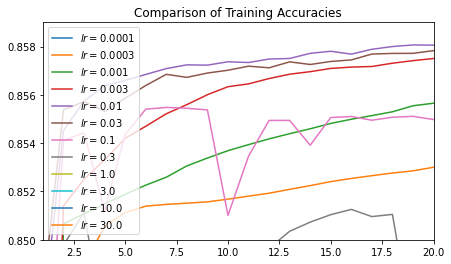

In [56]:
def plot_accuracies(row):
    #print(row.keys())
    lr = row["lr"].values[0]
    
    epochs = np.arange(1, 21, 1)
    
    mean_train = row["mean_train_accuracy"].values
    min_train = row["min_train_accuracy"].values
    max_train = row["max_train_accuracy"].values
    
    mean_val = row["mean_val_accuracy"].values
    min_val = row["min_val_accuracy"].values
    max_val = row["max_val_accuracy"].values
    
    plt.plot(epochs, mean_train, label=f"$lr = {lr}$")#"Training")
    
    #plt.plot(epochs, mean_val, label="Validation")

plt.figure(figsize=(7, 4))
plt.title("Comparison of Training Accuracies")

lror.apply(plot_accuracies, axis=1)
plt.ylim(0.85, 0.859)
plt.xlim(1, 20)
plt.legend()



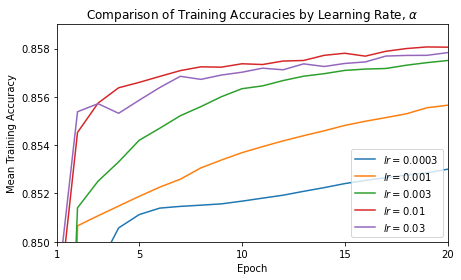

In [91]:
plt.figure(figsize=(7, 4))
plt.title(r"Comparison of Training Accuracies by Learning Rate, $\alpha$")

lror[lror.lr.isin((0.0003,0.001,0.003,0.01,0.03))].apply(plot_accuracies, axis=1)
plt.ylim(0.85, 0.859)
plt.xlim(1, 20)
plt.legend()

plt.xticks(np.hstack([np.array([1]), np.arange(5, 21, 5)]))

plt.xlabel("Epoch")
plt.ylabel("Mean Training Accuracy")

plt.savefig("lrcomp.png", dpi=1000)

## KNN

In [61]:
knn = pd.read_csv("knn.csv", index_col=0)
knn

,accuracy,tn,fp,fn,tp,roc_auc,sensitivity,specificity,precision
1,0.886087,108472,7859,7838,13629,0.783662,0.634881,0.932443,0.634261
2,0.900644,113458,2873,10818,10649,0.735683,0.496064,0.975303,0.787531
3,0.899520,110634,5697,8149,13318,0.785711,0.620394,0.951028,0.700394
4,0.902771,113107,3224,10174,11293,0.749175,0.526063,0.972286,0.777916
5,0.901610,111356,4975,8583,12884,0.778706,0.600177,0.957234,0.721429
...,...,...,...,...,...,...,...,...,...
96,0.875775,112757,3574,13544,7923,0.669178,0.369078,0.969277,0.689136
97,0.875956,112644,3687,13406,8061,0.671906,0.375507,0.968306,0.686159
98,0.875825,112767,3564,13547,7920,0.669151,0.368938,0.969363,0.689655
99,0.875535,112618,3713,13438,8029,0.671049,0.374016,0.968082,0.683785


In [63]:
knn.sort_values(["accuracy"], ascending=False).head(3).round(3)

,accuracy,tn,fp,fn,tp,roc_auc,sensitivity,specificity,precision
4,0.903,113107,3224,10174,11293,0.749,0.526,0.972,0.778
6,0.902,112949,3382,10101,11366,0.750,0.529,0.971,0.771
5,0.902,111356,4975,8583,12884,0.779,0.600,0.957,0.721


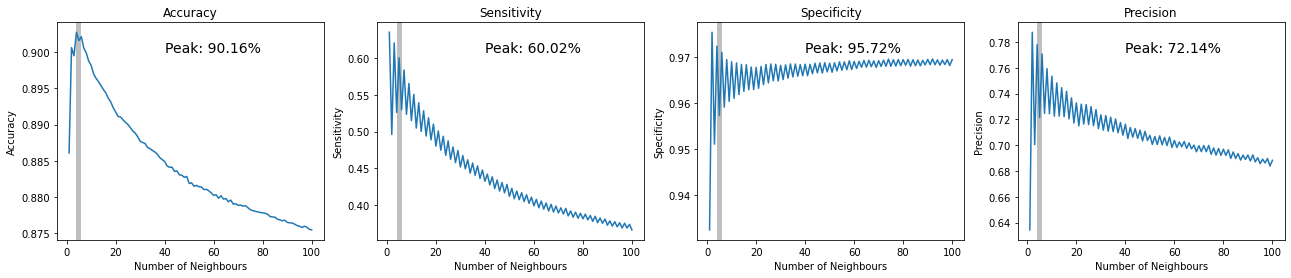

In [92]:
fig, axes = plt.subplots(1, 4, figsize=(22,4))

for i, metric in enumerate(["accuracy", "sensitivity", "specificity", "precision"]):
    axes[i].plot(knn[metric])
    axes[i].set(
        title = metric.title(),
        xlabel = "Number of Neighbours",
        ylabel = metric.title()
    )
    
    axes[i].axvspan(4, 6, facecolor ='0.5', alpha = 0.5)
    
    
    
    axes[i].text(40, 
                 knn[metric].min()+(knn[metric].max() - knn[metric].min())*0.9, 
                 f"Peak: {knn[metric].iloc[4]*100:0.2f}%", fontsize=14)

#plt.suptitle("K-Nearest Neighbours Variability Investigation")
# knn_df.accuracy.plot(
#     xlabel = "Number of Neighbours",
#     ylabel = "accuracy",
#     ax = ax
# )
plt.savefig("knn_comp.png", dpi=1000)